In [1]:
#@title 挂载google硬盘

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
#@title Import Library

from __future__ import print_function, division
import time
import os
import copy
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from PIL import Image  

In [3]:
#@title Figure Settings

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.ion()   # interactive mode

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = (8, 6)

In [76]:
#@title Data augmentation and normalization


data_transforms = transforms.Compose([
        #transforms.RandomRotation(30),
        #transforms.RandomPerspective(distortion_scale=0.1, p=0.5, interpolation=3, fill=0),
        transforms.RandomResizedCrop(120),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(), # 对我们的灰度图来说，这已经normalize了，把0~255map到01，直接除以255
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

先在自己的google硬盘里面，my drive目录下创建一个文件夹“kay”，然后把我给大家的压缩包放进去。

In [5]:
#@title 解压 kay/gallent dataset

%cd "drive/My Drive/stim"
#!unzip stimuli.zip  # 解压过了就不用运行这一句了

/content/drive/My Drive/stim


In [77]:
#@title 提取 kay/gallent dataset

data_dir = 'stimuli'

stim_datasets = datasets.ImageFolder(os.path.join(data_dir), transform=data_transforms)
class_names = stim_datasets.classes
dataset_sizes = {
    'train': 1500,
    'val': 250,
}
batch_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
#@title 把数据放到一个dataload里面

xx, yy = torch.utils.data.random_split(stim_datasets, [dataset_sizes['train'], dataset_sizes['val']])
dataloaders = {
    'train': torch.utils.data.DataLoader(xx, batch_size=20, shuffle=True, num_workers=8),
    'val': torch.utils.data.DataLoader(yy, batch_size=20, shuffle=True, num_workers=8),
}

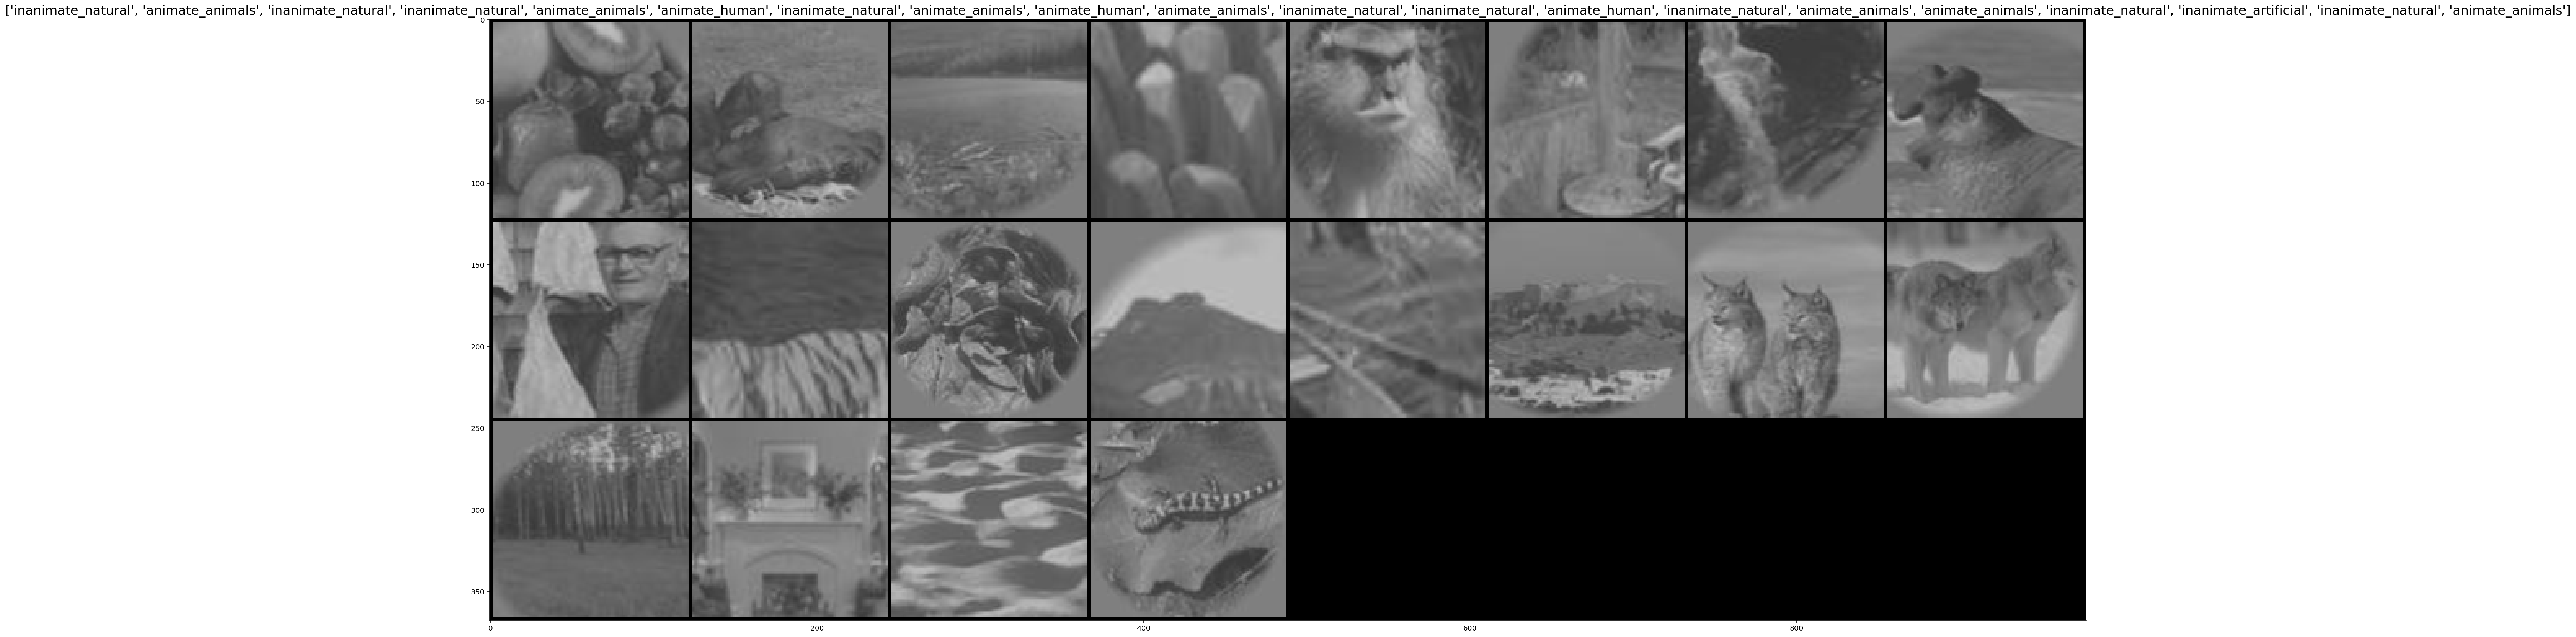

In [8]:
#@title Visualize a few images

def imshow(inp, title=None, figsize=[40, 25]):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        xx, yy = torch.utils.data.random_split(stim_datasets, [dataset_sizes['train'], dataset_sizes['val']])

        dataloaders = {
            'train': torch.utils.data.DataLoader(xx, batch_size=batch_size, shuffle=True, num_workers=8),
            'val': torch.utils.data.DataLoader(yy, batch_size=batch_size, shuffle=True, num_workers=8),
        }

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], figsize=[5, 5])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [33]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4. 因为我们是4类
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


NameError: ignored

## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.




In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 1.1052 Acc: 0.5113
val Loss: 1.3527 Acc: 0.3720

Epoch 1/29
----------
train Loss: 0.8068 Acc: 0.6913
val Loss: 1.8703 Acc: 0.3240

Epoch 2/29
----------
train Loss: 0.6752 Acc: 0.7553
val Loss: 1.6782 Acc: 0.3840

Epoch 3/29
----------
train Loss: 0.6488 Acc: 0.7540
val Loss: 0.6910 Acc: 0.7560

Epoch 4/29
----------
train Loss: 0.5227 Acc: 0.8093
val Loss: 0.9566 Acc: 0.6440

Epoch 5/29
----------
train Loss: 0.5671 Acc: 0.7853
val Loss: 0.7484 Acc: 0.7480

Epoch 6/29
----------
train Loss: 0.5070 Acc: 0.8107
val Loss: 1.1550 Acc: 0.5440

Epoch 7/29
----------
train Loss: 0.4874 Acc: 0.8200
val Loss: 0.5199 Acc: 0.8040

Epoch 8/29
----------
train Loss: 0.4808 Acc: 0.8160
val Loss: 0.3564 Acc: 0.8520

Epoch 9/29
----------
train Loss: 0.4102 Acc: 0.8433
val Loss: 0.4524 Acc: 0.8600

Epoch 10/29
----------
train Loss: 0.4521 Acc: 0.8280
val Loss: 0.4005 Acc: 0.8680

Epoch 11/29
----------
train Loss: 0.4314 Acc: 0.8433
val Loss: 0.3988 Acc: 0.8440

Ep

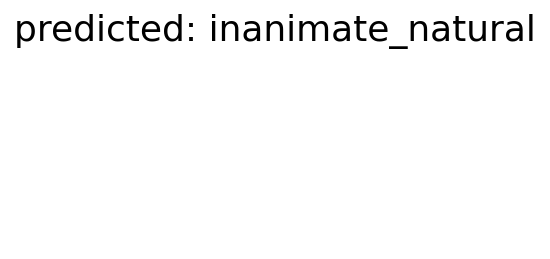

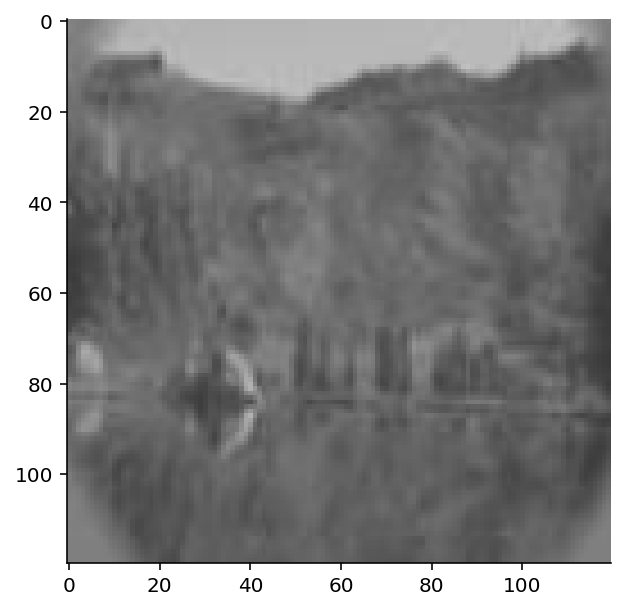

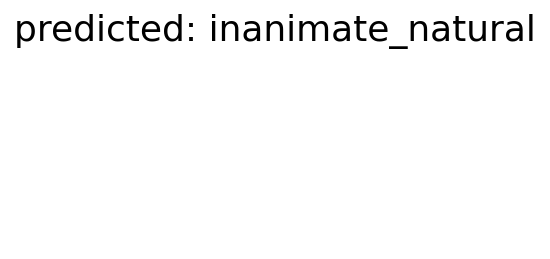

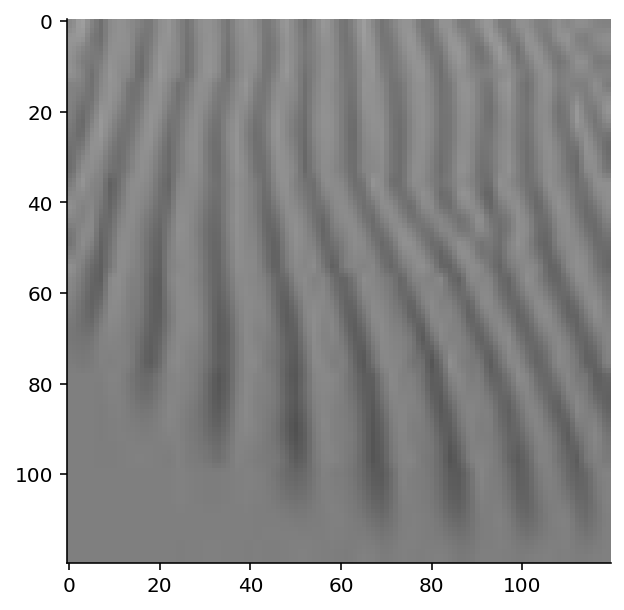

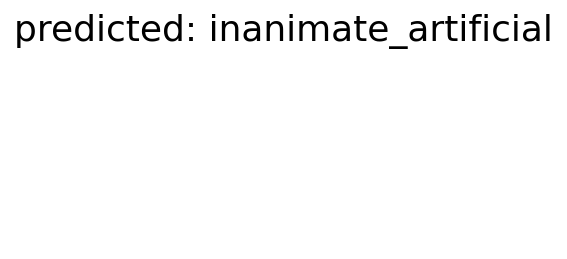

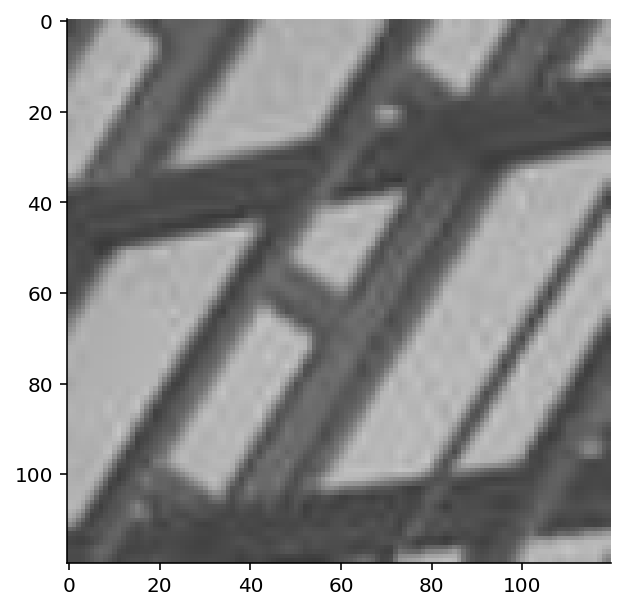

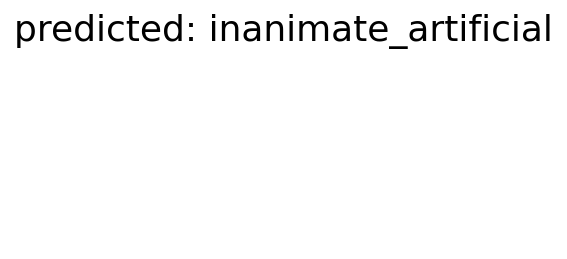

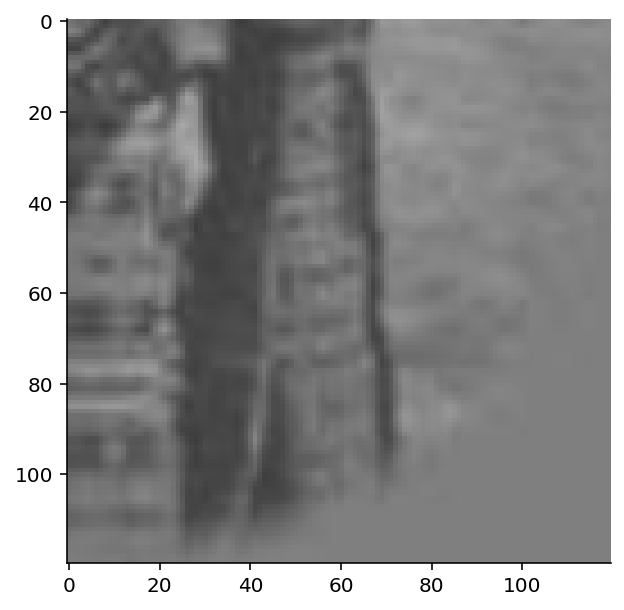

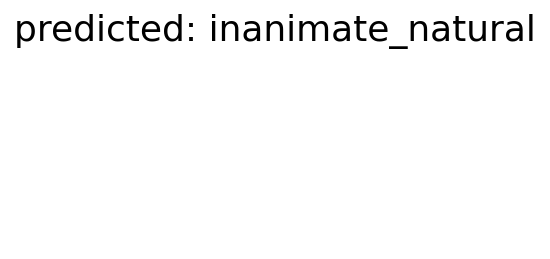

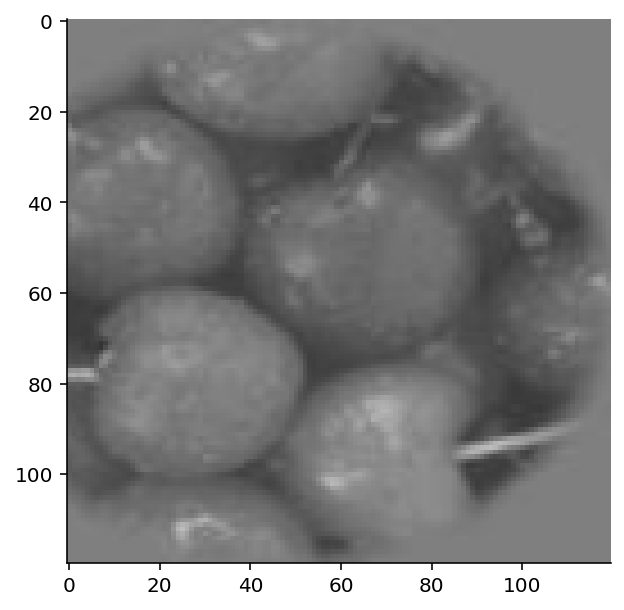

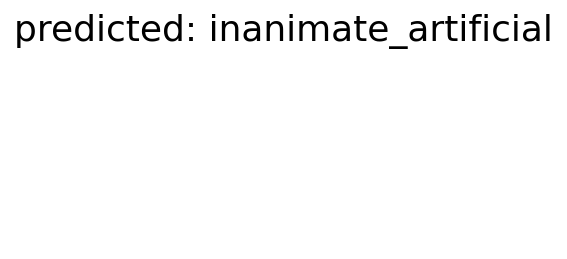

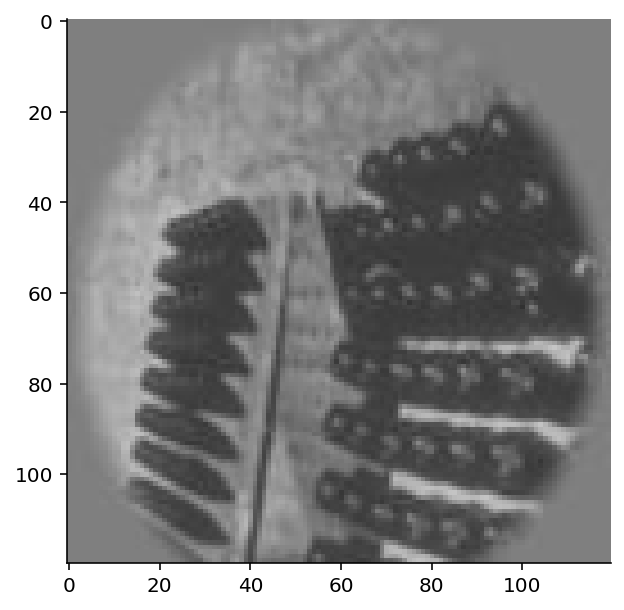

In [13]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.




In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2836 Acc: 0.4433
val Loss: 1.2377 Acc: 0.4400

Epoch 1/24
----------
train Loss: 0.9191 Acc: 0.6407
val Loss: 1.3375 Acc: 0.4960

Epoch 2/24
----------
train Loss: 0.8897 Acc: 0.6533
val Loss: 1.0864 Acc: 0.5480

Epoch 3/24
----------
train Loss: 0.8741 Acc: 0.6733
val Loss: 1.2006 Acc: 0.5880

Epoch 4/24
----------
train Loss: 0.8292 Acc: 0.6553
val Loss: 0.8421 Acc: 0.6720

Epoch 5/24
----------
train Loss: 0.8098 Acc: 0.6780
val Loss: 0.9540 Acc: 0.6240

Epoch 6/24
----------
train Loss: 0.8500 Acc: 0.6680
val Loss: 0.8756 Acc: 0.6480

Epoch 7/24
----------
train Loss: 0.7940 Acc: 0.6933
val Loss: 0.7266 Acc: 0.7200

Epoch 8/24
----------
train Loss: 0.7754 Acc: 0.6873
val Loss: 0.8257 Acc: 0.7120

Epoch 9/24
----------
train Loss: 0.7900 Acc: 0.6967
val Loss: 0.8513 Acc: 0.6760

Epoch 10/24
----------
train Loss: 0.7754 Acc: 0.6953
val Loss: 0.7103 Acc: 0.7320

Epoch 11/24
----------
train Loss: 0.7607 Acc: 0.7180
val Loss: 0.7376 Acc: 0.7080

Ep

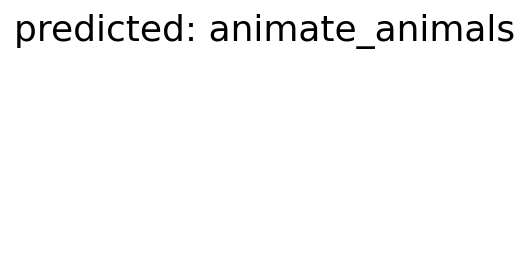

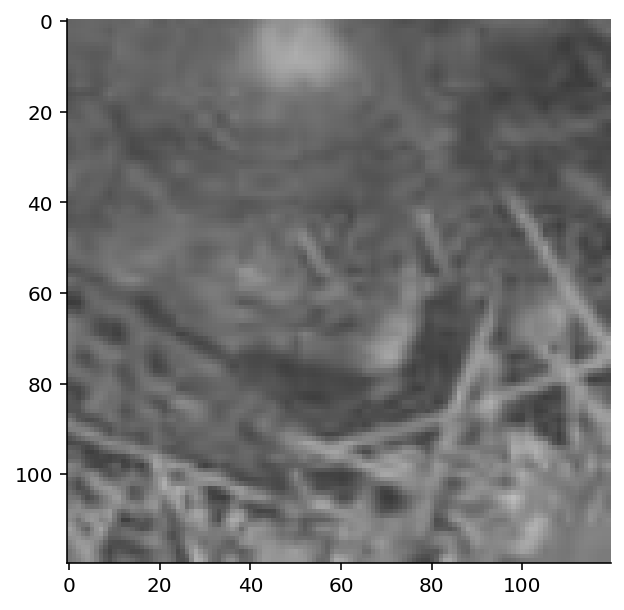

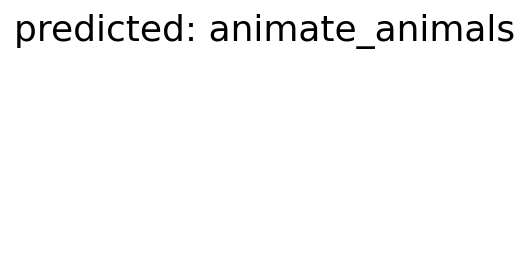

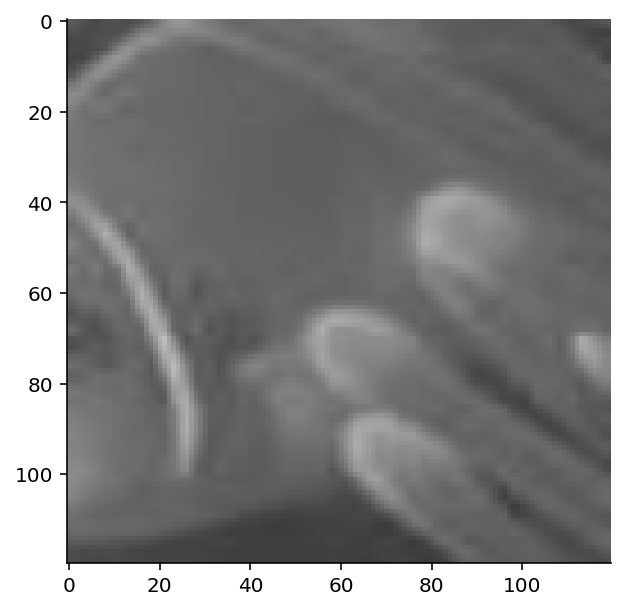

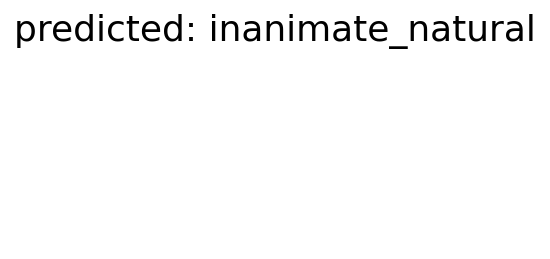

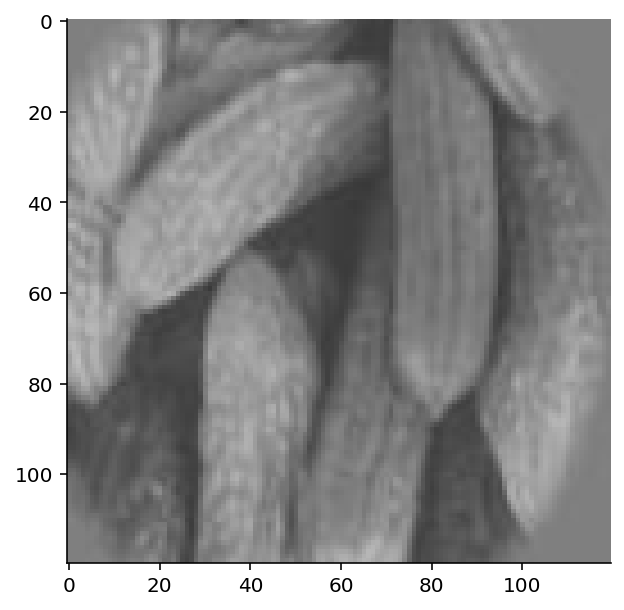

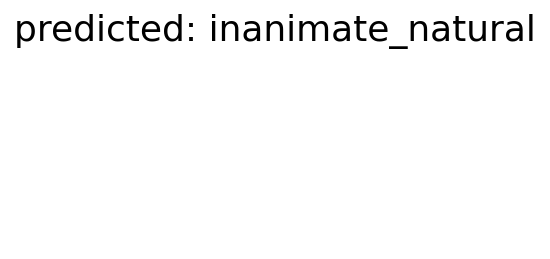

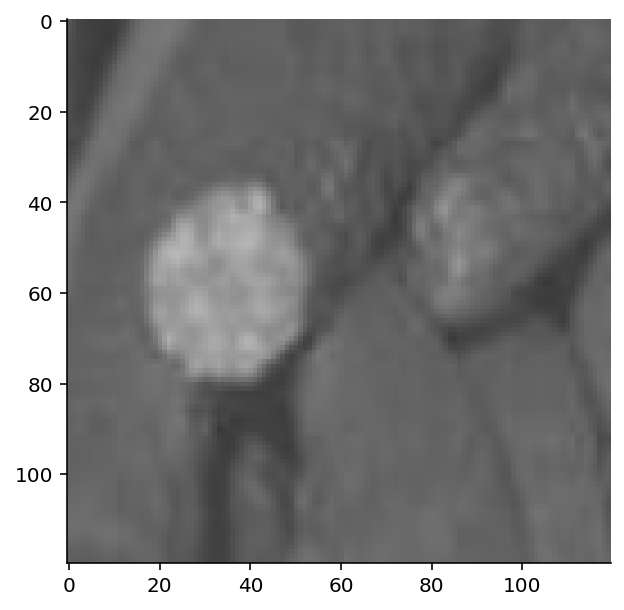

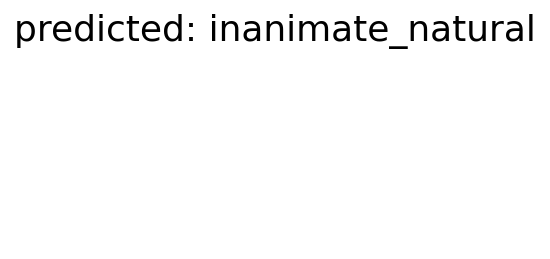

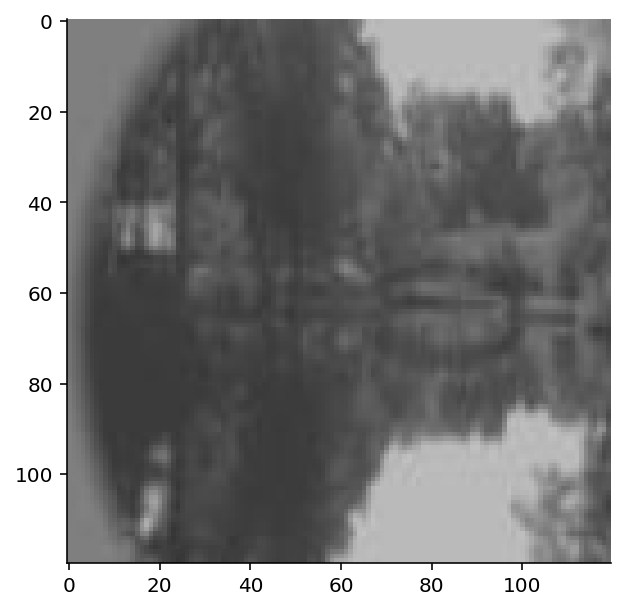

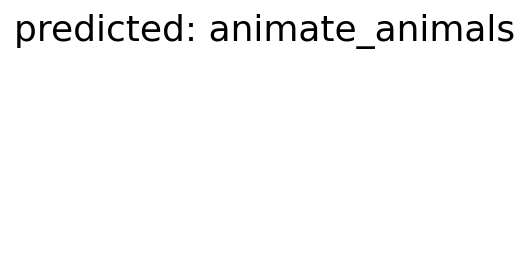

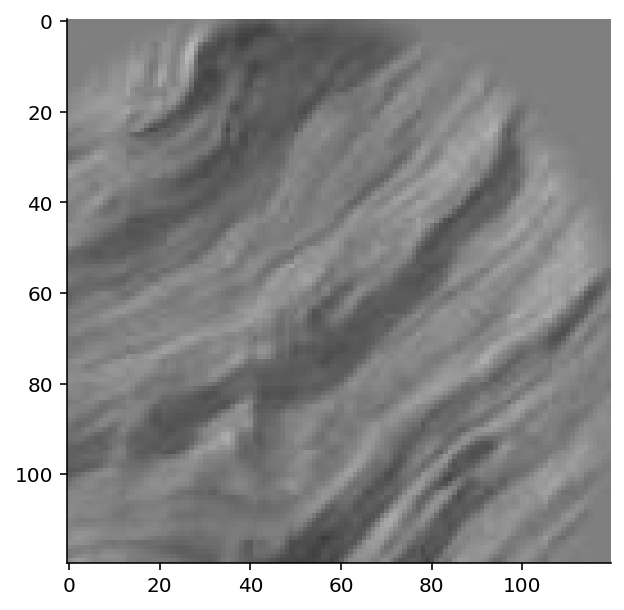

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





# 现在我们加载fMRI数据
因为比较小，我们直接读，不存在网盘
这里的labels是NMA mentors用NN预测出来的，我们用自己的labels

In [29]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [30]:
with np.load(fname) as dobj:
    dat = dict(**dobj)

In [31]:
categories = os.listdir(data_dir)

training_data = [0] * 1750 
training_labels = [0] * 1750 
training_labels_name = [0] * 1750 
labels2num = {str(categories[i]): i for i in range(len(categories))}

for category in categories:
    files = os.listdir(data_dir+'//' + category)
    for file in files:
        training_index = int(file.split("_")[0])
        #im = Image.open(data_dir + '//' + category + '//' + file)
        #training_data[training_index] = np.array(im)
        training_labels[training_index] = labels2num[category]
        training_labels_name[training_index] = category

#training_data = np.array(training_data)
training_labels = np.array(training_labels)

## BOLD信号

In [20]:
print(dat.keys())
print(dat["responses"].shape)
print(dat['roi'].shape)
print(dat['roi_names'])

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])
(1750, 8428)
(8428,)
['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']


In [21]:
V1_response = dat["responses"][:,dat['roi'] == 1]
V2_response = dat["responses"][:,dat['roi'] == 2]
V3_response = dat["responses"][:,dat['roi'] == 3]
V3A_response = dat["responses"][:,dat['roi'] == 4]
V3B_response = dat["responses"][:,dat['roi'] == 5]
V4_response = dat["responses"][:,dat['roi'] == 6]
LatOcc_response = dat["responses"][:,dat['roi'] == 7]

## RSA分析

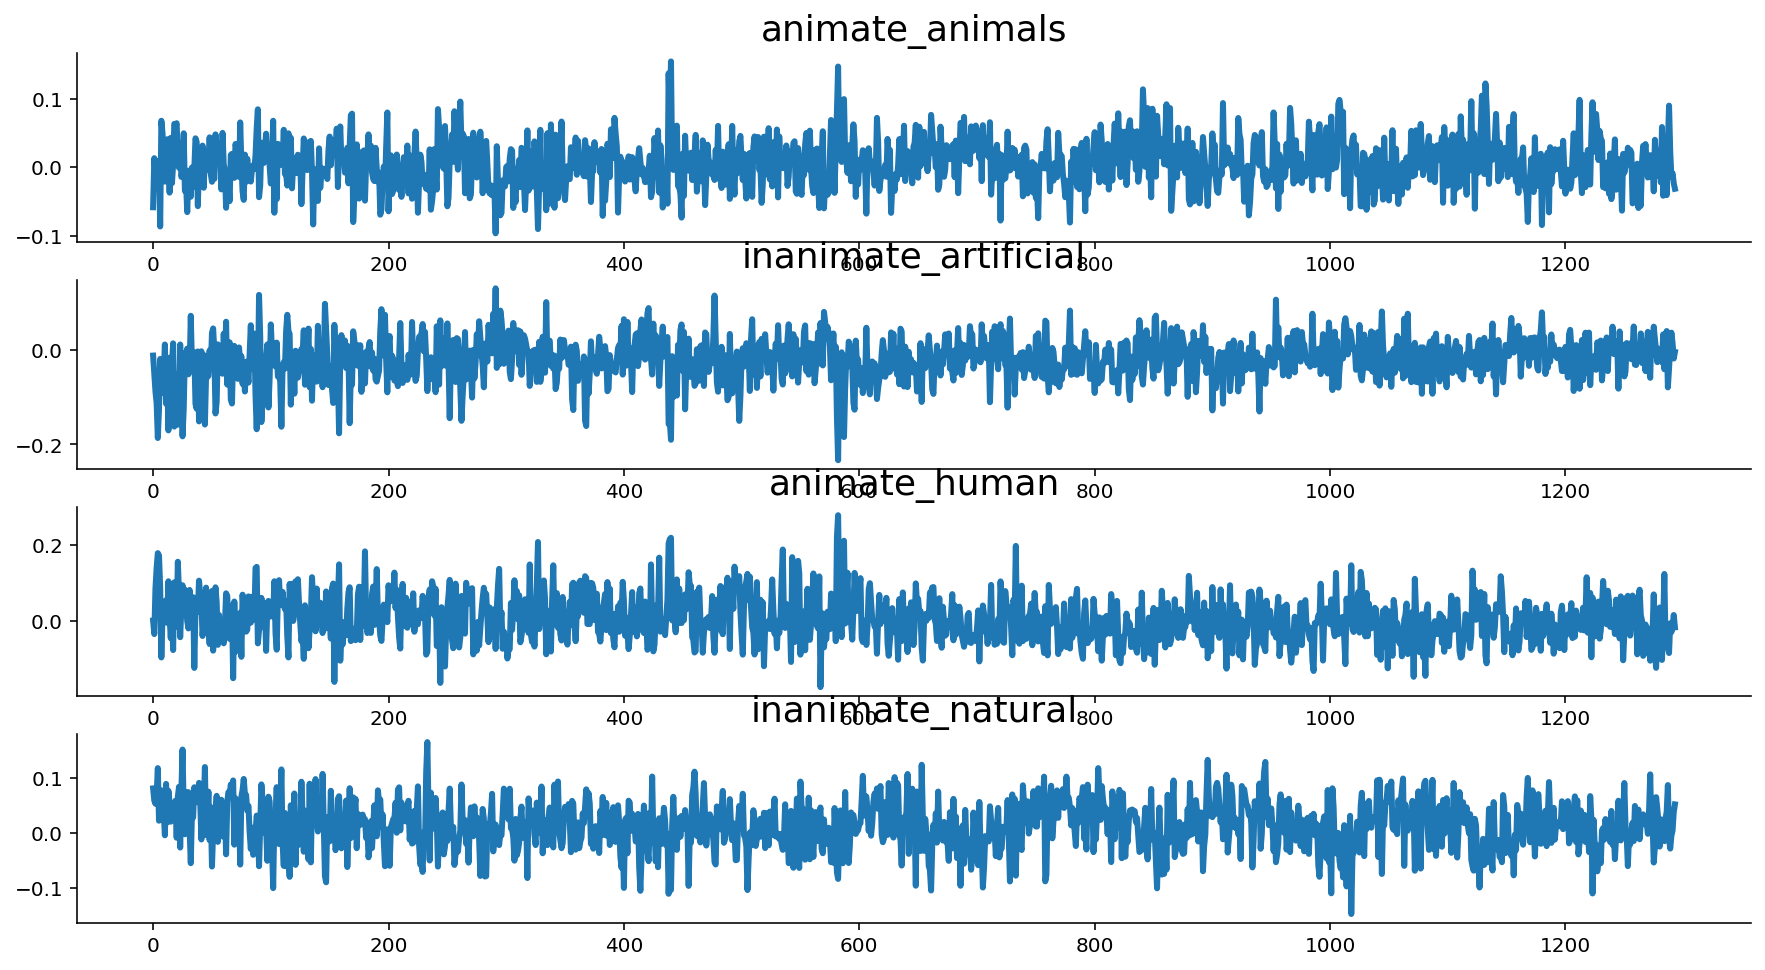

In [53]:
#@title plot stimulus-average response
V1_avg = np.zeros([4, V1_response.shape[1]])

fig, axes = plt.subplots(4, 1,figsize=[15, 8])
for i in range(4):
    V1_avg[i] = np.mean(V1_response[np.array(training_labels)==i], axis=0)
    axes[i].plot(V1_avg[i])
    axes[i].set_title(categories[i])

## TSNE 做聚类发现V1 response不可分？

In [54]:
def plot_dim_reduction(resp, stim, ax=None):
    """Plot dimensionality-reduced population responses (using tSNE)

    Args:
      resp (numpy array): n_stimuli x n_neurons matrix with population responses
      ori (numpy array): 1D array of length stimuli with orientations of each
        stimulus, in radians
      ax (matplotlib axes): axes onto which to plot

    """
    if ax is None:
        ax = plt.gca()

    # First do PCA to reduce dimensionality to 200 dimensions so that tSNE is faster
    resp_lowd = PCA(n_components=min(300, resp.shape[1])).fit_transform(resp)

    # Then do tSNE to reduce dimensionality to 2 dimensions
    resp_lowd = TSNE(n_components=2, perplexity=40, n_jobs=-1).fit_transform(resp_lowd)

    # Plot dimensionality-reduced population responses
    # on 2D axes, with each point colored by stimulus orientation
    scat = ax.scatter(resp_lowd[:, 0], resp_lowd[:, 1], c=stim, cmap='twilight')

    cbar = plt.colorbar(scat, ax=ax, label='stimulus orientation')
    ax.set_xlabel('dimension 1')
    ax.set_ylabel('dimension 2')
    ax.set_xticks([])
    ax.set_yticks([])

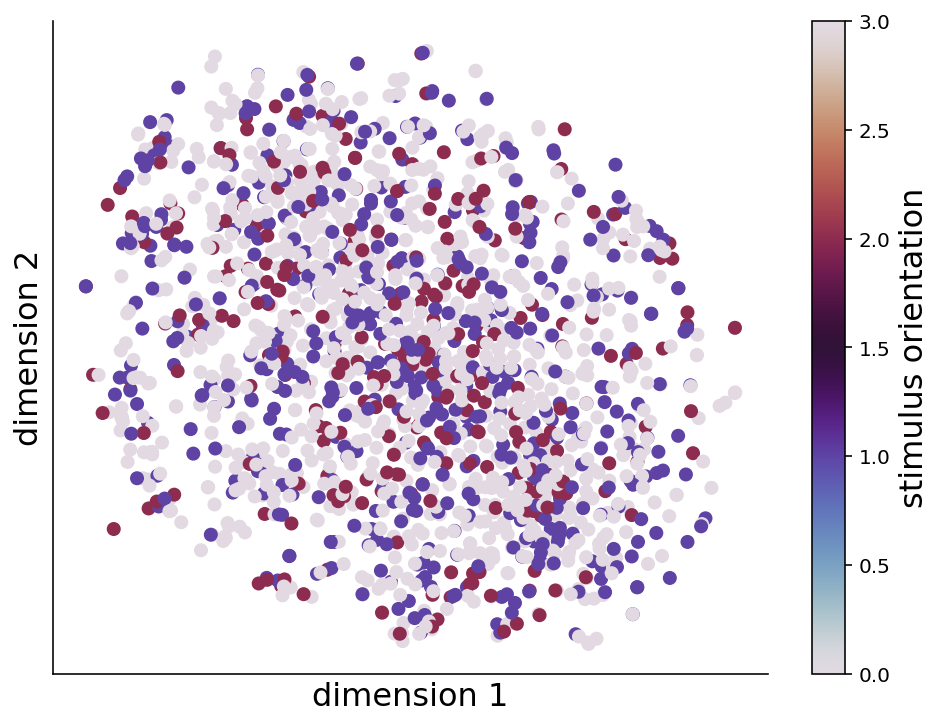

In [55]:
#@title tsne发现不可分
plot_dim_reduction(V1_response, training_labels)

## RDM
RDM 我写了两种方法，一种是用相关算的，一种用距离算的。

In [100]:
def plot_corr_matrix(rdm, ax=None, vmax=2.0):
    """Plot dissimilarity matrix

    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity 
        matrix
      ax (matplotlib axes): axes onto which to plot

    Returns:
      nothing
    
    """
    if ax is None:
      ax = plt.gca()

    cax = ax.imshow(rdm, vmin=0.0, vmax=vmax)
    ax.set_aspect('auto')

    if rdm.shape[0] == 4:
        ax.set_xticks([i for i in range(4)])
        ax.set_yticks([i for i in list(range(4))[::-1]])
        ax_label = list(labels2num.keys())
        ax.set_xticklabels([ax_label[i] for i in range(4)], rotation=30)
        ax.set_yticklabels([ax_label[i] for i in list(range(4))[::-1]], rotation=40)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = plt.colorbar(cax, ax=ax, label='correlation coefficient')

def RDM(resp, methods='corr'):
    """Compute the representational dissimilarity matrix (RDM)

    Args:
      resp: S x N matrix with population responses to
        each stimulus in each row
    
    Returns:
      np.ndarray: S x S representational dissimilarity matrix
    """
    if methods == 'corr':
        zresp = zscore(resp, axis=1)  # z-score responses to each stimulus
        result = 1 - (zresp @ zresp.T) / zresp.shape[1]
    elif methods == 'dist':
        # pdist just returns the upper triangle of the pairwise distance matrix
        pair_dist = pdist(resp)
        # to get the whole (20, 20) array we can use squareform
        result = squareform(pair_dist)
    return result

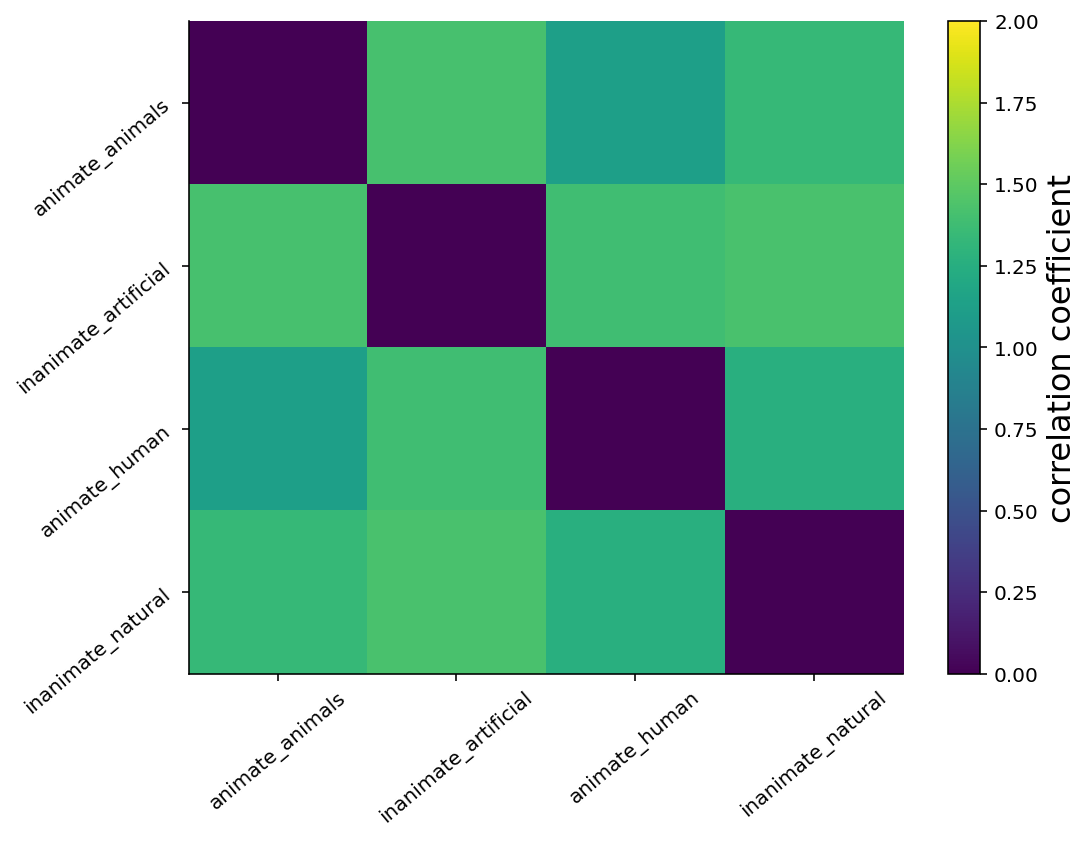

In [103]:
#@title 4分类的RDM看不出来什么
distance = RDM(V1_avg, 'corr')
plot_corr_matrix(distance, vmax=2)

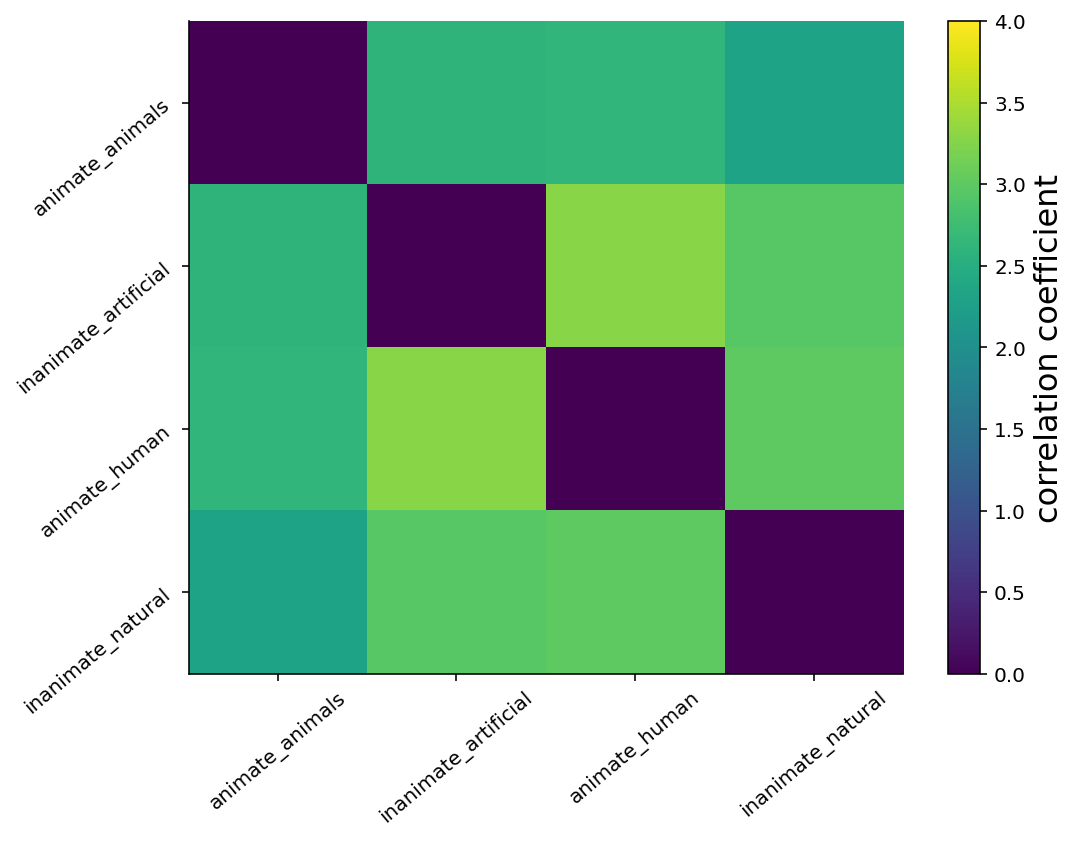

In [104]:
#@title 4分类的RDM看不出来什么
distance = RDM(V1_avg, 'dist')
plot_corr_matrix(distance, vmax=4)

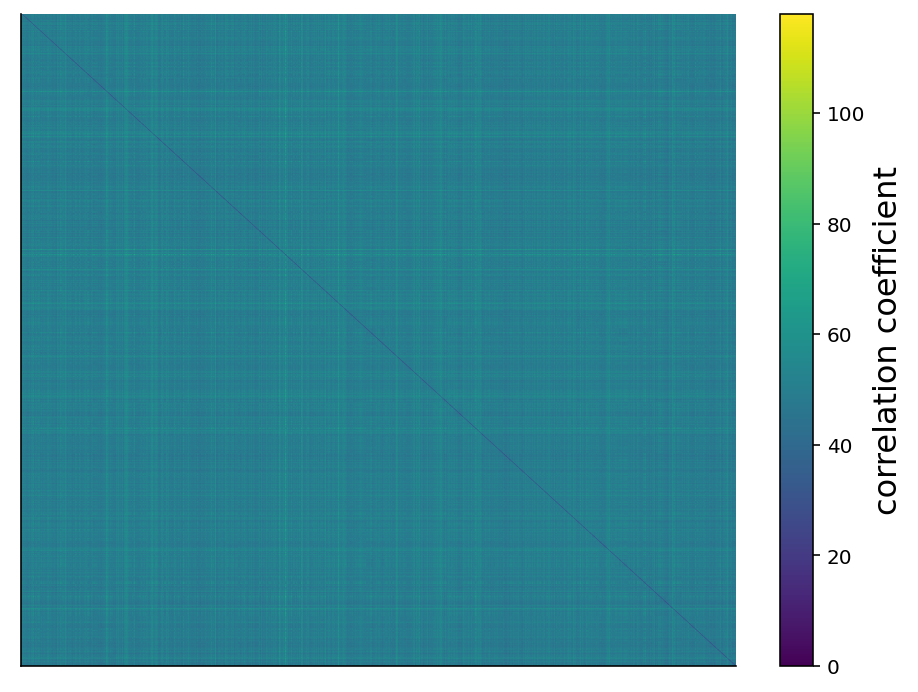

In [58]:
#@title 按照4分类sort stimuli以后感觉什么都没有
sort_idx = np.argsort(training_labels) # 按照我们分的labels sort
distance = RDM(V1_response[sort_idx], 'dist')
plot_corr_matrix(distance, vmax=np.max(distance))

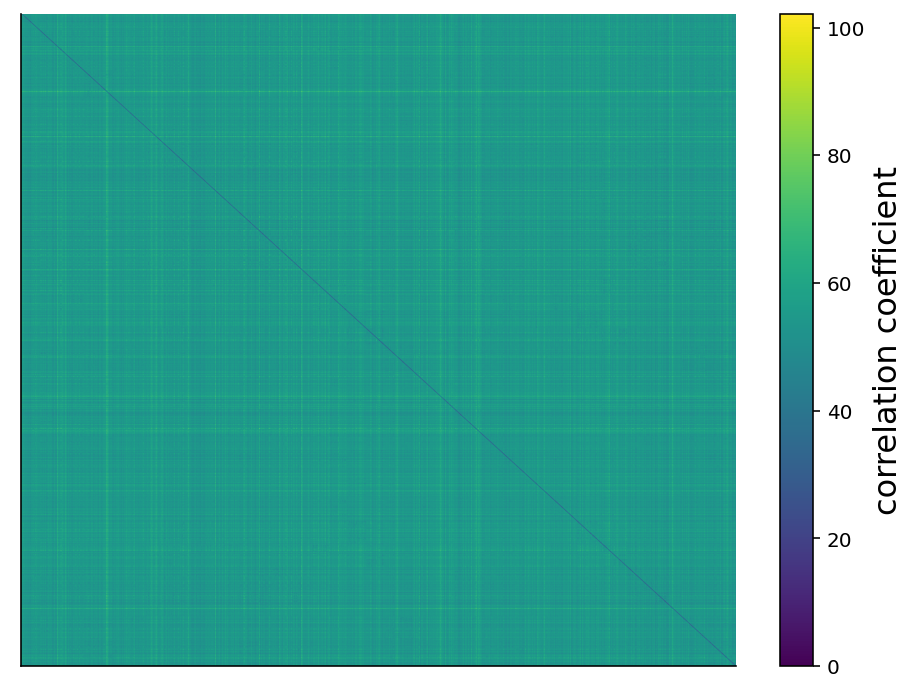

In [63]:
distance = RDM(V4_response[sort_idx], 'dist')
plot_corr_matrix(distance, vmax=np.max(distance))

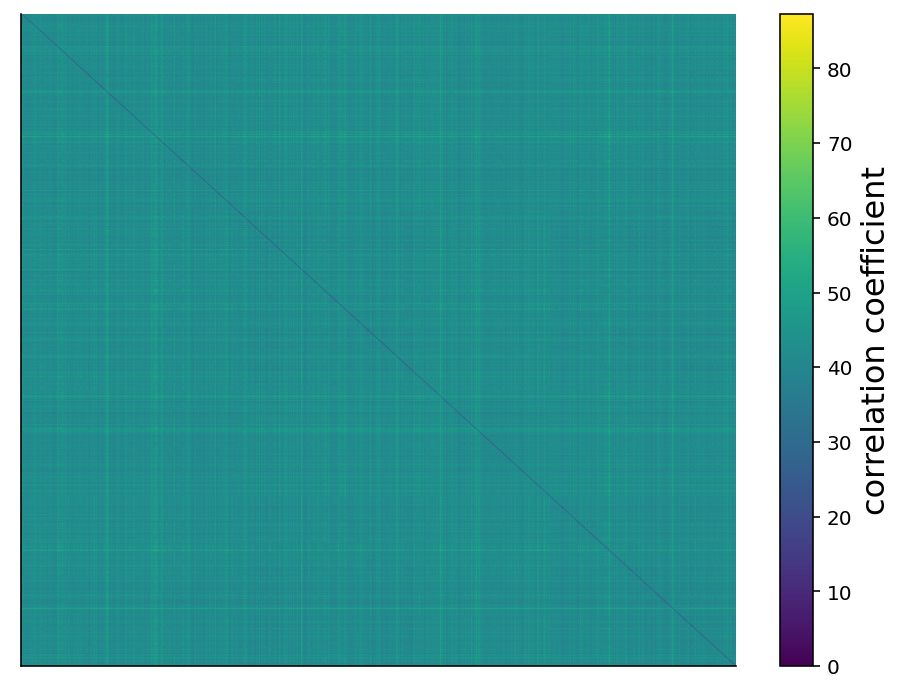

In [105]:
distance = RDM(LatOcc_response[sort_idx], 'dist')
plot_corr_matrix(distance, vmax=np.max(distance))

# 把神经网络的representation拿出来看看结果
Goal: extracting our deep CNN model's representations of these same stimuli

We'll run these very same stimuli through our CNN model and use the get_hidden_activity() function to store its internal representations. The output of this function is a Python dict, which contains a matrix of population responses (just like resp_v1) for each layer of the network specified by the layer_labels argument. 

We'll focus on looking at the representations in the outputs of the first pooling layer, stored in the model as 'pool1' the outputs of the second pooling layer, stored in the model as 'pool2' the 10-dimensional outputs of the fully connected layer, stored in the model as 'fc'

In [79]:
def get_hidden_activity(net, stimuli, layer_labels):
    """Retrieve internal representations of network

    Args:
      net (nn.Module): deep network
      stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to 
        compute and retrieve internal representations
      layer_labels (list): list of strings with labels of each layer for which
        to return its internal representations

    Returns:
      dict: internal representations at each layer of the network, in
        numpy arrays. The keys of this dict are the strings in layer_labels.

    """

    # Placeholder
    hidden_activity = {}

    # Attach 'hooks' to each layer of the network to store hidden
    # representations in hidden_activity
    def hook(module, input, output):
        module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
        if module_label in layer_labels:  # ignore output layer
            hidden_activity[module_label] = output.view(stimuli.shape[0], -1).detach().numpy()
    hooks = [layer.register_forward_hook(hook) for layer in net.children()]

    # Run stimuli through the network
    for inputs, labels in stimuli:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = net(inputs)

    #pred = net(stimuli)
    
    # Remove the hooks
    [h.remove() for h in hooks]

    return hidden_activity

In [39]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
model_ft._modules.keys()

odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [45]:
model_ft._modules['layer1'][0][]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [81]:
stimuli = torch.utils.data.DataLoader(stim_datasets, batch_size=len(stim_datasets), num_workers=8)
layer_labels = ['fc']
resp_model = get_hidden_activity(model_ft, stimuli, layer_labels)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0c98d85278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


RuntimeError: ignored